In [3]:
#imports

import os
import glob
import tqdm
import random

import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
#load data
vehicle_images = glob.glob('vehicles/vehicles/*/*.png')
non_vehicle_images = glob.glob('non-vehicles/non-vehicles/*/*.png')


In [3]:
#read images and augment
cars = []
for car_file in vehicle_images:
    car_img = mpimg.imread(car_file)
    cars.append(car_img)
    cars.append(cv2.flip(car_img,1))
    
noncars = []
for noncar_file in non_vehicle_images:
    noncar_img = mpimg.imread(noncar_file)
    noncars.append(noncar_img)

### Preprocess data

In [4]:
X = np.vstack((cars, noncars)).astype(np.float64)
y = np.hstack((np.ones(len(cars)), np.zeros(len(noncars))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=rand_state)

In [5]:
model = Sequential()
model.add(Conv2D(8, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))



In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
generator = ImageDataGenerator( featurewise_center=True,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                rotation_range=20.,
                                width_shift_range=0.4,
                                height_shift_range=0.4,
                                shear_range=0.2,
                                zoom_range=0.2,
                                channel_shift_range=0.1,
                                fill_mode='nearest',
                                horizontal_flip=True,
                                vertical_flip=False,
                                rescale=1.2,
                                preprocessing_function=None)

In [8]:
generator.fit(X_train)

In [9]:


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

model.fit_generator(generator.flow(X_train, y_train, batch_size=256),
                    steps_per_epoch= int(len(X_train) / 100),
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))
                    

Epoch 1/100
199/199 [==============================] - 72s - loss: 0.3388 - acc: 0.8524 - val_loss: 2.2105 - val_acc: 0.3365
Epoch 2/100
199/199 [==============================] - 59s - loss: 0.1739 - acc: 0.9265 - val_loss: 1.9299 - val_acc: 0.3983
Epoch 3/100
199/199 [==============================] - 58s - loss: 0.1471 - acc: 0.9391 - val_loss: 0.3788 - val_acc: 0.8444
Epoch 4/100
199/199 [==============================] - 60s - loss: 0.1260 - acc: 0.9489 - val_loss: 0.1324 - val_acc: 0.9458
Epoch 5/100
199/199 [==============================] - 58s - loss: 0.1157 - acc: 0.9544 - val_loss: 0.1545 - val_acc: 0.9361
Epoch 6/100
199/199 [==============================] - 58s - loss: 0.1055 - acc: 0.9585 - val_loss: 0.2581 - val_acc: 0.9077
Epoch 7/100
199/199 [==============================] - 59s - loss: 0.0924 - acc: 0.9642 - val_loss: 0.2224 - val_acc: 0.9187
Epoch 8/100
199/199 [==============================] - 58s - loss: 0.0895 - acc: 0.9659 - val_loss: 0.1978 - val_acc: 0.9316


In [11]:
eval_result = model.evaluate(X_test, y_test)
print('Test accuracy:', eval_result[1])

6624/6638 [============================>.] - ETA: 0sTest accuracy: 0.988852063946


In [12]:
#window sizes obtained by experimentation
window_sizes = [
                 (50,50),
                 (80,80),
                 (135,135),
                 (190,190) ]


In [13]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Select the region on the image where the car is located

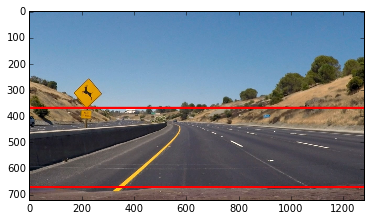

In [15]:
test_images = glob.glob('test_images/*.jpg')
img = mpimg.imread(test_images[1])
roi_up = 370
roi_down = 670
cv2.rectangle(img, (0,roi_up), (img.shape[1],roi_down) , (255,0,0), 8)
plt.imshow(img)
plt.show()

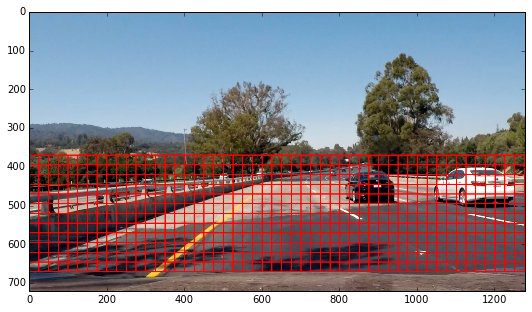

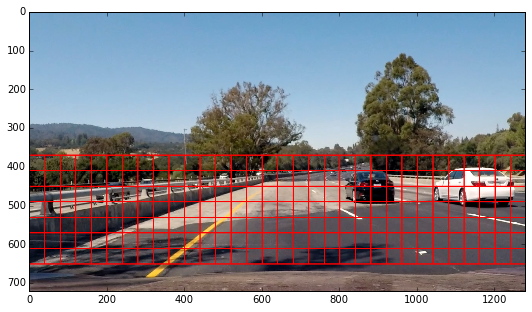

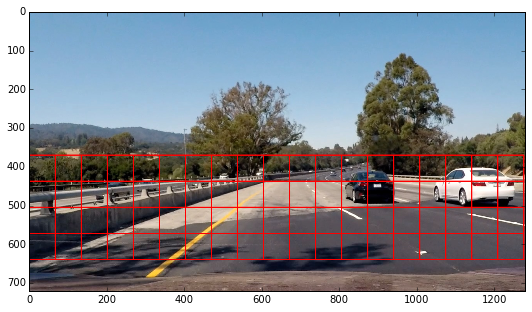

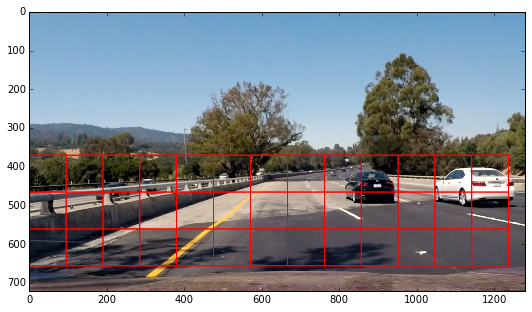

In [16]:
img = mpimg.imread(test_images[3])
for win_size in window_sizes:
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[roi_up, roi_down], 
                        xy_window=win_size, xy_overlap=(0.5, 0.5))
    window_img = draw_boxes(img, windows, color=(255, 0, 0), thick=2)
    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(window_img)
    plt.show()

### overlap all windows together

814


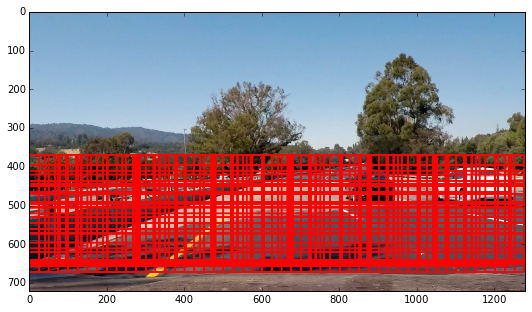

In [18]:
# Plot all together
img = mpimg.imread(test_images[3])
windows = []
for win_size in window_sizes:
    windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[roi_up, roi_down], 
                        xy_window=win_size, xy_overlap=(0.5, 0.5))
print(len(windows))
window_img = draw_boxes(img, windows, color=(255, 0, 0), thick=3)
# Plot
plt.figure(figsize=(10, 5))
plt.imshow(window_img)
plt.show()

#### Search and Classify

In [19]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, model):
    #1) Create an empty list to receive positive detection windows
    #2) Iterate over all windows in the list
    test_images = []
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Normalize image
        test_img = test_img/255
        # Predict and round the result
        test_images.append(test_img)
    test_images = np.array(test_images)

    prediction = np.round(model.predict(test_images))
    on_windows = [windows[i] for i in np.where(prediction==1)[0]]
    return on_windows

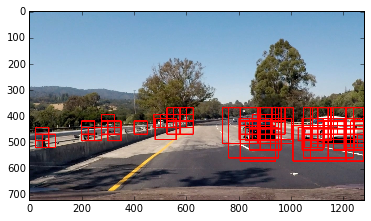

In [20]:
img = mpimg.imread(test_images[3])

detected_windows = search_windows(img, windows, model)                       

window_img = draw_boxes(img, detected_windows, color=(255, 0, 0), thick=3)                    

plt.imshow(window_img)


In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
       
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 5)
    # Return the image
    return img

In [22]:
def process(img):
    # Get model and windows list
    global last_heat_map, use_n_frames
    hot_windows = search_windows(img, windows, model)                       
    # Define heatmap
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    heatmap = heatmap.reshape(1,*heatmap.shape)
    
    
    heatmap = heatmap[0]
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

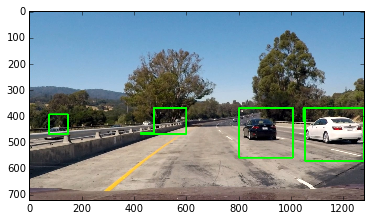

In [23]:
img = mpimg.imread('test_images/test1.jpg')
plt.imshow(process(img))

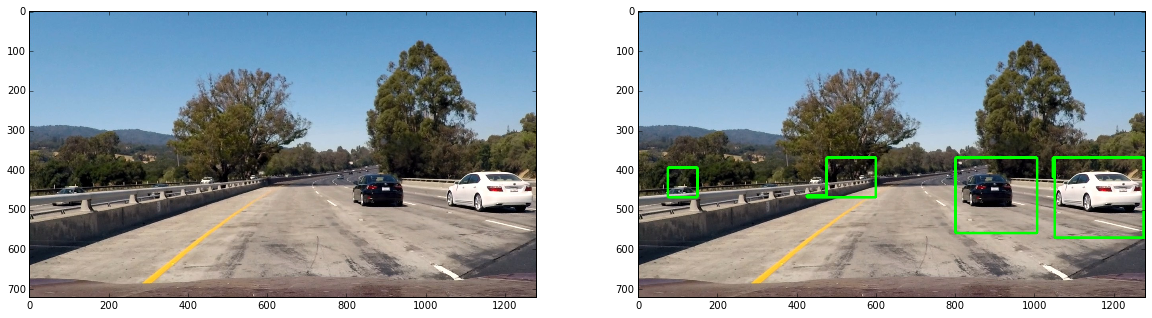

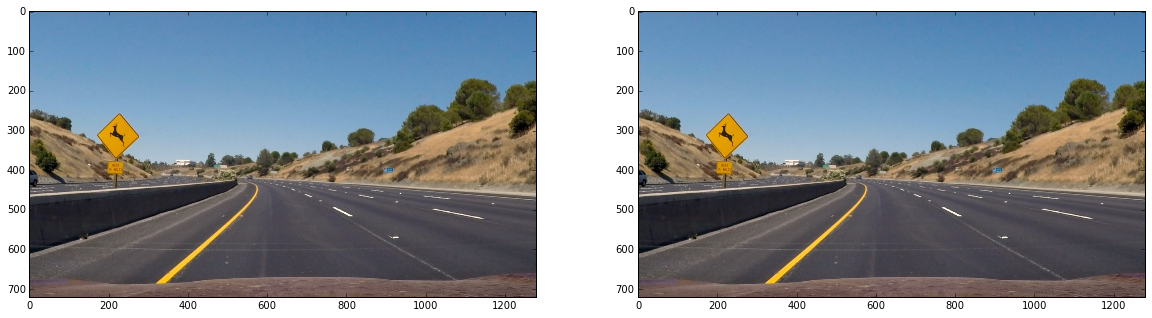

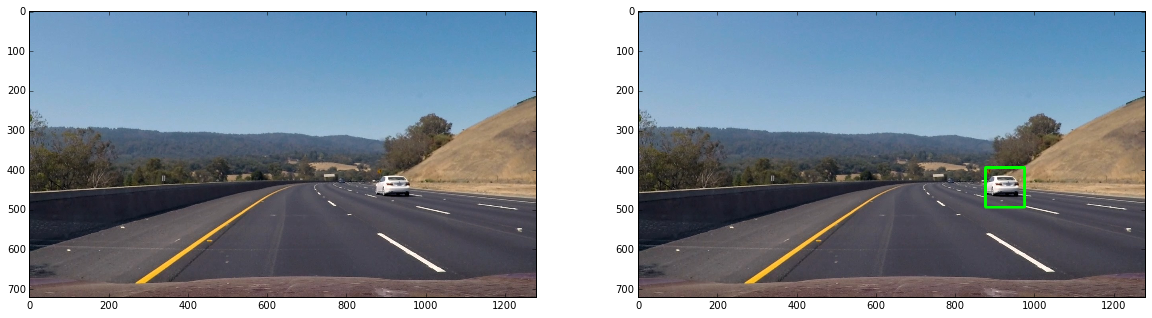

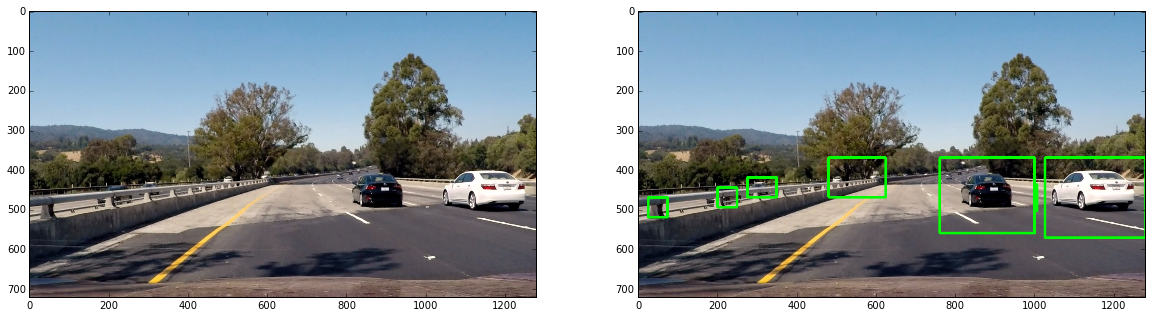

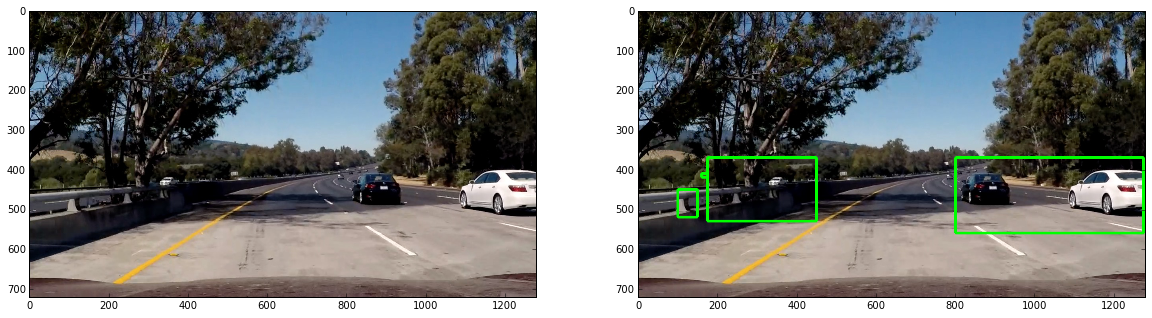

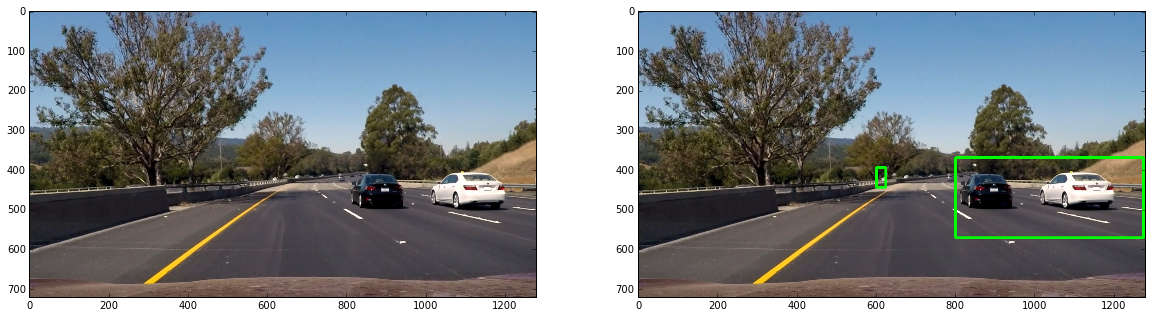

In [24]:
i = 0
for img_name in test_images:   
    img = mpimg.imread(img_name)
    result = process(img)
    global i
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(img)
    ax2.imshow(result)
    name = 'result' + str(i) +'.jpg'
    i = i + 1
    cv2.imwrite('output_images/' + name, result)

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:54<00:00,  2.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 9min 55s
